In [2]:
shape = (150, 150, 3)
image_size = 150
path = "./Images/"

In [1]:
import os
import glob as gb
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm


def read_images_from_directory(
    folder_path,
    desc,
):
    images = []
    labels = []

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + "/" + folder + "/*.jpg"))

        for file in tqdm(files, desc=desc + " in " + folder):
            image = plt.imread(file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(folder)
    return images, labels

In [3]:
images, labels = read_images_from_directory(path, "Loading Data")

Loading Data in pituitary_tumor: 100%|██████████| 4504/4504 [00:25<00:00, 177.95it/s]


In [4]:
from sklearn.preprocessing import LabelBinarizer

x_data = np.array(images)
lb = LabelBinarizer()
y_data = lb.fit_transform(labels)

In [5]:
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42
)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential


from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D

In [42]:
densenet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
    pooling="avg",
)

In [49]:
for layer in densenet.layers:
    layer.trainable = False

model = densenet.output
model = Dense(512, activation="relu")(model)
model = Dense(256, activation="relu")(model)
pred = Dense(4, activation="softmax")(model)
model = Model(inputs=densenet.input, outputs=pred)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [50]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_14 (ZeroPadding  (None, 156, 156, 3)  0          ['input_8[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d_14[0][0]']      
                                                                                            

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [52]:
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=earlystop,
)

Epoch 1/50
353/353 [==============================] - 59s 130ms/step - loss: 1.0090 - accuracy: 0.6647 - val_loss: 0.6597 - val_accuracy: 0.7192
Epoch 2/50
353/353 [==============================] - 40s 115ms/step - loss: 0.5468 - accuracy: 0.7800 - val_loss: 0.6483 - val_accuracy: 0.7457
Epoch 3/50
353/353 [==============================] - 40s 114ms/step - loss: 0.4691 - accuracy: 0.8175 - val_loss: 0.4357 - val_accuracy: 0.8348
Epoch 4/50
353/353 [==============================] - 40s 113ms/step - loss: 0.4169 - accuracy: 0.8360 - val_loss: 0.4467 - val_accuracy: 0.8369
Epoch 5/50
353/353 [==============================] - 42s 119ms/step - loss: 0.3674 - accuracy: 0.8592 - val_loss: 0.4270 - val_accuracy: 0.8318
Epoch 6/50
353/353 [==============================] - 42s 118ms/step - loss: 0.3471 - accuracy: 0.8626 - val_loss: 0.6496 - val_accuracy: 0.7638
Epoch 7/50
353/353 [==============================] - 42s 118ms/step - loss: 0.3101 - accuracy: 0.8795 - val_loss: 0.4865 - val_ac

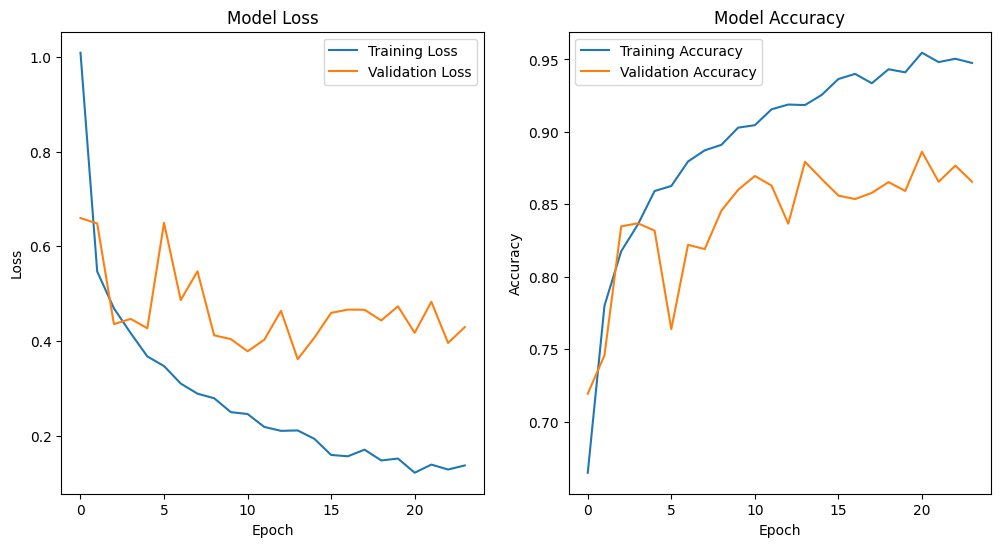

In [53]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [54]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 10s 84ms/step - loss: 0.3325 - accuracy: 0.8889
Test accuracy: 0.8889479041099548
Test loss: 0.33252575993537903


In [29]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 15s 81ms/step


In [55]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [56]:
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Accuracy: 0.8658342189160467
Precision: 0.8659193191485798
Recall: 0.8658342189160467
F1 Score: 0.8652469803156382


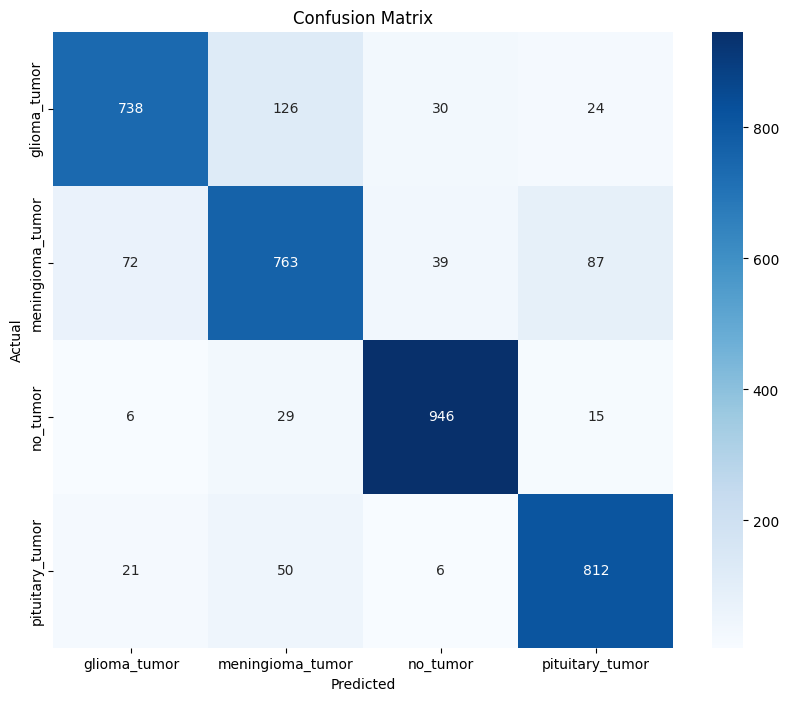

In [57]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [58]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "DenseNet201_01(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\DenseNet201_01(150x150).h5


In [ ]:
densenet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
    pooling="avg",
)
model = densenet.output
model = Dense(512, activation="relu")(model)
model = Dense(256, activation="relu")(model)
pred = Dense(4, activation="softmax")(model)
model = Model(inputs=densenet.input, outputs=pred)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=earlystop,
)

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

In [ ]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "DenseNet201_02(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")